In [1]:
import os
import sys
from glob import glob
from networks.denseNet import DenseNet

import torch
from PIL import Image
from torch.utils.data import DataLoader
from torch.nn import MSELoss

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib.colors import ListedColormap

import numpy as np
import SimpleITK as sitk
import random

import monai
from monai.data import Dataset, decollate_batch
from monai.inferers import sliding_window_inference
from monai.metrics import MAEMetric, MSEMetric, PSNRMetric
from monai.utils.type_conversion import convert_to_numpy
from monai.data.utils import list_data_collate
from monai.transforms import (
    Activations,
    AddChanneld,
    AsDiscrete,
    Compose,
    LoadImaged,
    RandFlipd,
    Flipd,
    RandRotate90,
    RandSpatialCrop,
    ScaleIntensityd,
    ConcatItemsd,
    MapTransform,
    ToTensord,
    EnsureType,
    EnsureTyped,
)
from utils_wasserstein.utils import im2vec, vec2im, psnr
from utils_wasserstein.ot import sliced_wasserstein
from utils_wasserstein.tools import approach_by_wasserstein

# Selection de bassin ou tete

Coupe du bassin

In [52]:
path = "C:/Users/julien.heurtin/Documents/Stage_2A/Data_Medical/Autrescoupes/bassin"
nvl_coupesFilenames = []
dirNames = os.path.join(path, 'test_*')

for i in range(5):
    
    edepLowFilename = os.path.join(path, 'test_%02i_in.mhd' % i)
    edepHighFilename = os.path.join(path, 'test_%02i_lbl.mhd' % i)
    ctFilename = os.path.join(path, 'test_%02i_ct.mhd' % i) 
    
    tmpDict = {'dose': edepLowFilename, 'lbl': edepHighFilename, 'ct': ctFilename}
    
    nvl_coupesFilenames.append(tmpDict)

Coupe de la tête 

In [36]:
path = "C:/Users/julien.heurtin/Documents/Stage_2A/Data_Medical/Autrescoupes/tete"
nvl_coupesFilenames = []
dirNames = os.path.join(path, 'test_*')

i = 5
edepLowFilename = os.path.join(path, 'test_%02i_in.mhd' % i)
edepHighFilename = os.path.join(path, 'test_%02i_lbl.mhd' % i)
ctFilename = os.path.join(path, 'test_%02i_ct.mhd' % i) 
    
tmpDict = {'dose': edepLowFilename, 'lbl': edepHighFilename, 'ct': ctFilename} 
nvl_coupesFilenames.append(tmpDict)

In [53]:
test_transforms = Compose(
    [
        LoadImaged(keys=['dose', 'lbl', 'ct'], image_only=True),
        ToTensord(keys=['dose', 'lbl', 'ct']),
        AddChanneld(keys=['dose', 'lbl', 'ct']),
        ConcatItemsd(keys=['dose', 'ct'], name='img'),
        EnsureTyped(keys=['img', 'lbl'])
    ]
)

test_ds = Dataset(data=nvl_coupesFilenames, transform=test_transforms)
test_loader = DataLoader(
    test_ds, 
    batch_size=1, 
    num_workers=1, 
    collate_fn=list_data_collate,
    pin_memory=torch.cuda.is_available(),
)

<class 'monai.transforms.utility.dictionary.AddChanneld'>: Class `AddChanneld` has been deprecated since version 0.8. It will be removed in version 1.3. please use MetaTensor data type and monai.transforms.EnsureChannelFirstd instead with `channel_dim='no_channel'`.
monai.transforms.utility.dictionary EnsureChannelFirstd.__init__:meta_keys: Argument `meta_keys` has been deprecated since version 0.9. not needed if image is type `MetaTensor`.


In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model1 = DenseNet(
    spatial_dims=2, 
    in_channels=2,
    out_channels=1, 
    init_features=64, 
    growth_rate=32, 
    block_config=(4, 8, 16, 8), 
    bn_size=4
    ).to(device)

model2 = DenseNet(
    spatial_dims=2, 
    in_channels=2,
    out_channels=1, 
    init_features=64, 
    growth_rate=32, 
    block_config=(4, 8, 16, 8), 
    bn_size=4
    ).to(device)

psnr_metric1 = PSNRMetric(max_val=1.0)
psnr_metric2 = PSNRMetric(max_val=1.0)

post_trans = Compose([EnsureType()])

In [55]:
model1Path = "./results_thorax_pancreas/PSNR/best_model.pth"
model1.load_state_dict(torch.load(model1Path))

model2Path = "./results_thorax/PSNR/best_model.pth"
model2.load_state_dict(torch.load(model2Path))

<All keys matched successfully>

Selectionner le outpath pour tete ou bassin

In [56]:
# pour le bassin
outPath = "C:/Users/julien.heurtin/Documents/Stage_2A/Data_Medical/Autrescoupes/test_DenseNet_bassin_post_pancreas"

In [60]:
# pour la tete
outPath = "C:/Users/julien.heurtin/Documents/Stage_2A/Data_Medical/Autrescoupes/test_DenseNet_tete_post_pancreas"

In [57]:
model1.eval()
model2.eval()
with torch.no_grad():
    test_inputs = None
    test_outputs = None
    for count, test_data in enumerate(test_loader):
        
        test_inputs = test_data['img'].to(device)
        test_labels = test_data['lbl'].to(device)
        roi_size = (64, 64)
        sw_batch_size = 1

        test_outputs1 = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model1)
        test_outputs1 = [post_trans(i) for i in decollate_batch(test_outputs1)]
        
        test_outputs2 = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model2)
        test_outputs2 = [post_trans(i) for i in decollate_batch(test_outputs2)]
        
        inp=convert_to_numpy(test_inputs[0][0])
        ct=convert_to_numpy(test_inputs[0][1])
        lbl=convert_to_numpy(test_labels[0][0])
        out1=convert_to_numpy(test_outputs1[0][0])
        out2=convert_to_numpy(test_outputs2[0][0])

        inpITK = sitk.GetImageFromArray(inp)
        lblITK = sitk.GetImageFromArray(lbl)
        outITK1 = sitk.GetImageFromArray(out1)
        outITK2 = sitk.GetImageFromArray(out2)
        ctITK = sitk.GetImageFromArray(ct)
        
        sitk.WriteImage(inpITK, os.path.join(outPath, 'test_%03i_in.mhd' % count))
        sitk.WriteImage(lblITK, os.path.join(outPath, 'test_%03i_lbl.mhd' % count))
        sitk.WriteImage(outITK1, os.path.join(outPath, 'test_%03i_out.mhd' % count))
        sitk.WriteImage(outITK2, os.path.join(outPath, 'test_%03i_out_post_pancreas.mhd' % count))
        sitk.WriteImage(ctITK, os.path.join(outPath, 'test_%03i_ct.mhd' % count))

        psnr_metric1(y_pred=test_outputs1, y=test_labels)
        psnr_metric2(y_pred=test_outputs2, y=test_labels)
    
    # get the final metric results
    test_psnr_1 = psnr_metric1.aggregate().item()
    test_psnr_2 = psnr_metric2.aggregate().item()
    psnr_metric1.reset()
    psnr_metric2.reset()

print('val PSNR sans pancreas:', test_psnr_2)
print('val PSNR avec pancreas:', test_psnr_1)

val PSNR sans pancreas: 28.784637451171875
val PSNR avec pancreas: 30.811786651611328


In [49]:
top = cm.get_cmap('viridis', 64)
bottom = cm.get_cmap('plasma', 960)
newcolors = np.vstack((top(np.linspace(0, 1, 64)),
                       bottom(np.linspace(1, 0, 960))))
newcmp = ListedColormap(newcolors, name='MonteCarlo')

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


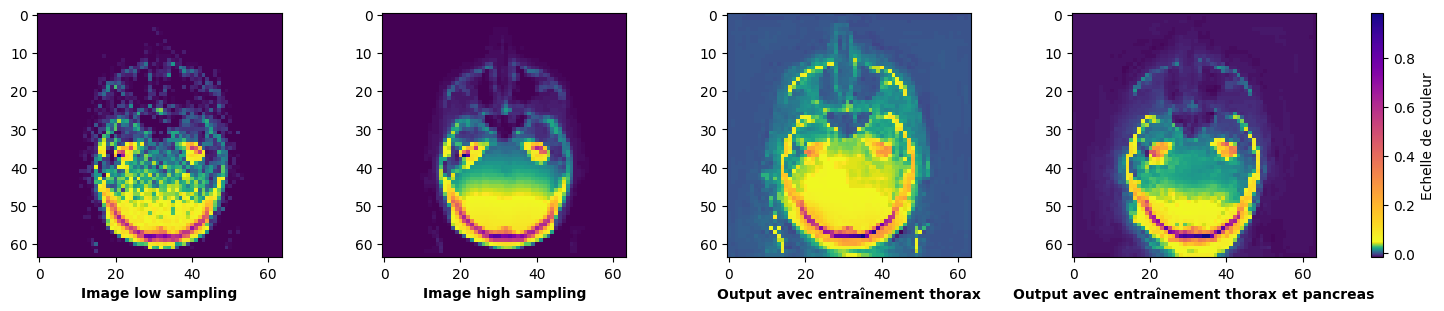

In [61]:
for i in range(1):

    reelImg = sitk.ReadImage(os.path.join(outPath, 'test_%03i_lbl.mhd' % i), imageIO='MetaImageIO')
    lbl = sitk.GetArrayFromImage(reelImg)

    inputImg = sitk.ReadImage(os.path.join(outPath, 'test_%03i_in.mhd' % i), imageIO='MetaImageIO')
    input = sitk.GetArrayFromImage(inputImg)

    outputImg = sitk.ReadImage(os.path.join(outPath, 'test_%03i_out_post_pancreas.mhd' % i), imageIO='MetaImageIO')
    output = sitk.GetArrayFromImage(outputImg)
    
    outputImg = sitk.ReadImage(os.path.join(outPath, 'test_%03i_out.mhd' % i), imageIO='MetaImageIO')
    output2 = sitk.GetArrayFromImage(outputImg)

    fig = plt.figure(constrained_layout=True, figsize=(15, 3))
    spec = gridspec.GridSpec(ncols=4, nrows=1, figure=fig)

    ax1 = fig.add_subplot(spec[0])
    plt.imshow(input, interpolation=None, cmap=newcmp)
    plt.xlabel('Image low sampling',fontweight='bold')

    ax2 = fig.add_subplot(spec[1])
    plt.imshow(lbl, interpolation=None, cmap=newcmp)
    plt.xlabel('Image high sampling',fontweight='bold')

    ax3 = fig.add_subplot(spec[2])
    plt.imshow(output2, interpolation=None, cmap=newcmp)
    plt.xlabel('Output avec entraînement thorax',fontweight='bold')
    
    ax4 = fig.add_subplot(spec[3])
    plt.imshow(output, interpolation=None, cmap=newcmp)
    plt.xlabel('Output avec entraînement thorax et pancreas',fontweight='bold')

    cbar = fig.colorbar(ax3.imshow(output2, interpolation=None, cmap=newcmp), ax=[ax1, ax2, ax3, ax4], fraction=0.046, pad=0.04)
    cbar.set_label('Echelle de couleur') 